## Importing dependencies and data

In [1]:
import re
import nltk
import string
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

In [2]:
if not nltk.corpus.stopwords.fileids():
    nltk.download('stopwords')
if not nltk.data.find('tokenizers/punkt'):
    nltk.download('punkt')
if not nltk.corpus.wordnet.fileids():
    nltk.download('wordnet')

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
translator = str.maketrans('', '', string.punctuation)

In [4]:
files = glob.glob("hashtagless*.csv")
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)
tweets = pd.concat(dfs, ignore_index=True)
print(len(tweets))
tweets.head()

200000


,Author,Tweet Text,Hashtags
0,Hakimar14,Momentarily making a broken heart romance genr...,NaN
1,VikingDM1,@JVandepitte1 @War_Mapper Again Warmapper only...,NaN
2,SeanySharksfynn,@GBNEWS We should stop messing about with this...,NaN
3,stephenituruka,@sotirissays China is shaping up to be this gl...,NaN
4,green_horizons_,People like memeing reagan's or biden's anti-u...,NaN


## Cleaning data

In [5]:
def clean(df):
    stop_words = set(stopwords.words('english'))
    df['Tweet Text'] = df['Tweet Text'].str.lower()
    df['Tweet Text'] = df['Tweet Text'].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s]", "", x))
    df['Tweet Text'] = df['Tweet Text'].apply(lambda x: re.sub(r"[^\w\s]", "", x))
    df['Tweet Text'] = df['Tweet Text'].apply(lambda x: re.sub(r"http\S+|www\S+|https\S+", "", x))
    df['Tweet Text'] = df['Tweet Text'].apply(lambda x: re.sub(r"\S+@\S+", "", x))
    df.drop_duplicates(subset='Tweet Text', inplace=True)
    df['Tweet Text'] = df['Tweet Text'].str.lower()
    
    # Remove stop words
    df['Tweet Text'] = df['Tweet Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    
    return df

In [6]:
cleanTweets = clean(tweets)
print(len(cleanTweets))
cleanTweets.head()

26525


,Author,Tweet Text,Hashtags
0,Hakimar14,momentarily making broken heart romance genre ...,NaN
1,VikingDM1,jvandepitte1 warmapper warmapper reports geoco...,NaN
2,SeanySharksfynn,gbnews stop messing proxy war tell putin get u...,NaN
3,stephenituruka,sotirissays china shaping glove fits purpose l...,NaN
4,green_horizons_,people like memeing reagans bidens antiunion p...,NaN


In [7]:
any(cleanTweets['Tweet Text'].isnull())

False

## Tokenizing and Vectorising data

In [8]:
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    return tokens

cleanTweets['Tokenized Text'] = cleanTweets['Tweet Text'].apply(tokenize_text)
cleanTweets.head()

,Author,Tweet Text,Hashtags,Tokenized Text
0,Hakimar14,momentarily making broken heart romance genre ...,NaN,"[momentarily, making, broken, heart, romance, ..."
1,VikingDM1,jvandepitte1 warmapper warmapper reports geoco...,NaN,"[jvandepitte1, warmapper, warmapper, reports, ..."
2,SeanySharksfynn,gbnews stop messing proxy war tell putin get u...,NaN,"[gbnews, stop, messing, proxy, war, tell, puti..."
3,stephenituruka,sotirissays china shaping glove fits purpose l...,NaN,"[sotirissays, china, shaping, glove, fits, pur..."
4,green_horizons_,people like memeing reagans bidens antiunion p...,NaN,"[people, like, memeing, reagans, bidens, antiu..."


In [9]:
def vectorize(tweet):
    word_embeddings = [model.wv[word] for word in tweet if word in model.wv]
    if len(word_embeddings) > 0:
        return sum(word_embeddings) / len(word_embeddings)
    else:
        return None

model = Word2Vec(cleanTweets['Tokenized Text'], vector_size=100, window=5, min_count=1, workers=4)
cleanTweets['Vectorized Text'] = cleanTweets['Tokenized Text'].apply(vectorize)
cleanTweets = cleanTweets.dropna(subset=['Vectorized Text'])
# vectors = cleanTweets['Vectorized Text']
print(len(cleanTweets))
cleanTweets.head()

26521


,Author,Tweet Text,Hashtags,Tokenized Text,Vectorized Text
0,Hakimar14,momentarily making broken heart romance genre ...,NaN,"[momentarily, making, broken, heart, romance, ...","[-0.27949047, 0.25552598, 0.41383076, 0.158187..."
1,VikingDM1,jvandepitte1 warmapper warmapper reports geoco...,NaN,"[jvandepitte1, warmapper, warmapper, reports, ...","[-0.22044499, 0.25073504, 0.3714911, 0.1653433..."
2,SeanySharksfynn,gbnews stop messing proxy war tell putin get u...,NaN,"[gbnews, stop, messing, proxy, war, tell, puti...","[-0.5268982, 0.47556123, 0.6045142, 0.14311145..."
3,stephenituruka,sotirissays china shaping glove fits purpose l...,NaN,"[sotirissays, china, shaping, glove, fits, pur...","[-0.33220515, 0.27334517, 0.37972194, 0.103878..."
4,green_horizons_,people like memeing reagans bidens antiunion p...,NaN,"[people, like, memeing, reagans, bidens, antiu...","[-0.2588772, 0.26315266, 0.3724944, 0.14745925..."


## K means Clustering and Assigning Tags

### K means Clustering with random initial points

In [10]:
X = np.vstack(cleanTweets['Vectorized Text'].values)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
cleanTweets['Cluster'] = kmeans.labels_

In [11]:
cleanTweets

,Author,Tweet Text,Hashtags,Tokenized Text,Vectorized Text,Cluster
0,Hakimar14,momentarily making broken heart romance genre ...,NaN,"[momentarily, making, broken, heart, romance, ...","[-0.27949047, 0.25552598, 0.41383076, 0.158187...",0
1,VikingDM1,jvandepitte1 warmapper warmapper reports geoco...,NaN,"[jvandepitte1, warmapper, warmapper, reports, ...","[-0.22044499, 0.25073504, 0.3714911, 0.1653433...",0
2,SeanySharksfynn,gbnews stop messing proxy war tell putin get u...,NaN,"[gbnews, stop, messing, proxy, war, tell, puti...","[-0.5268982, 0.47556123, 0.6045142, 0.14311145...",2
3,stephenituruka,sotirissays china shaping glove fits purpose l...,NaN,"[sotirissays, china, shaping, glove, fits, pur...","[-0.33220515, 0.27334517, 0.37972194, 0.103878...",0
4,green_horizons_,people like memeing reagans bidens antiunion p...,NaN,"[people, like, memeing, reagans, bidens, antiu...","[-0.2588772, 0.26315266, 0.3724944, 0.14745925...",0
...,...,...,...,...,...,...
190181,GreGor_451245,colonelratliff remarks war bahmut war attritio...,NaN,"[colonelratliff, remarks, war, bahmut, war, at...","[-0.4786578, 0.4152466, 0.53456455, 0.16881791...",2
190274,delsylvania,people programs physically unable work america...,NaN,"[people, programs, physically, unable, work, a...","[-0.4702587, 0.47857, 0.49356842, 0.22203429, ...",1
190391,TheAstrosLocker,aaron hicks played 88 games 2017 59 games 2019...,NaN,"[aaron, hicks, played, 88, games, 2017, 59, ga...","[-0.31266966, 0.33161545, 0.51486295, 0.173974...",1
190591,CindyWalte93162,5444292center evening war,"['富婆', '张家辉', '空投']","[5444292center, evening, war]","[-0.34484327, 0.23543513, 0.25230804, 0.084330...",0


#### We can check for most frequent words in each cluster

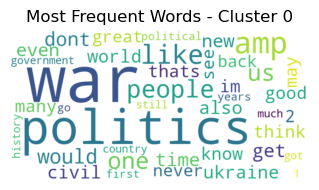

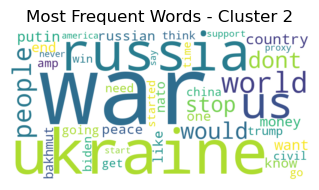

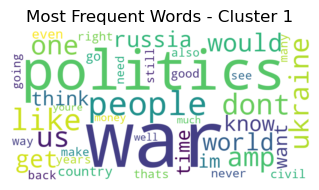

In [12]:
from wordcloud import WordCloud
from collections import Counter

cluster_labels = cleanTweets['Cluster'].unique()
num_words = 40
wordcloud_params = {
    'background_color': 'white',
    'max_words': num_words,
    'width': 800,
    'height': 400,
    'prefer_horizontal': 0.9,
    'collocations': False
}

for label in cluster_labels:
    cluster_data = cleanTweets[cleanTweets['Cluster'] == label]
    cluster_text = ' '.join(cluster_data['Tokenized Text'].apply(lambda x: ' '.join(x)))
    words = cluster_text.split()
    word_frequencies = Counter(words)
    wordcloud = WordCloud(**wordcloud_params)
    wordcloud.generate_from_frequencies(word_frequencies)
    
    plt.figure(figsize=(4, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Frequent Words - Cluster {label}')
    plt.axis('off')
    plt.tight_layout()

    plt.show()


### Tagging using SentimentIntensityAnalyzer for Comparison

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

cleanTweets['Sentiment'] = cleanTweets['Tweet Text'].apply(lambda x: sia.polarity_scores(x)['compound'])
cleanTweets['Sentiment Label'] = cleanTweets['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/rass/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


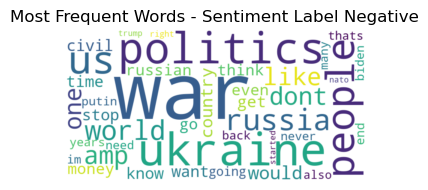

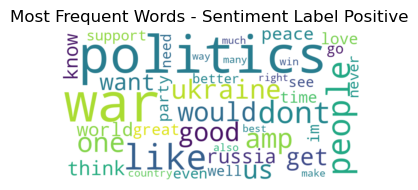

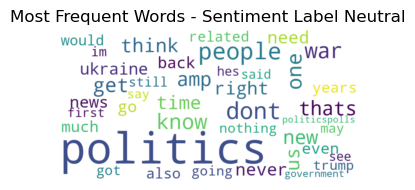

In [14]:
sentiment_labels = cleanTweets['Sentiment Label'].unique()
num_words = 40

for label in sentiment_labels:
    cluster_data = cleanTweets[cleanTweets['Sentiment Label'] == label]
    cluster_text = ' '.join(cluster_data['Tokenized Text'].apply(lambda x: ' '.join(x)))
    words = cluster_text.split()
    word_frequencies = Counter(words)
    wordcloud = WordCloud(**wordcloud_params)
    wordcloud.generate_from_frequencies(word_frequencies)
    
    plt.figure(figsize=(4, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Frequent Words - Sentiment Label {label}')
    plt.axis('off')
    plt.tight_layout()

    plt.show()


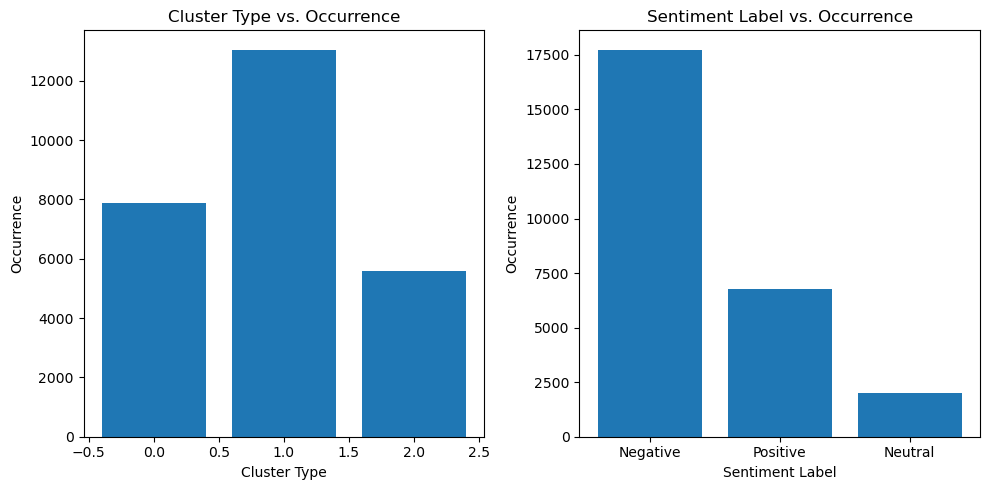

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
cluster_counts = cleanTweets['Cluster'].value_counts()
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster Type')
plt.ylabel('Occurrence')
plt.title('Cluster Type vs. Occurrence')

plt.subplot(1, 2, 2)
sentiment_counts = cleanTweets['Sentiment Label'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment Label')
plt.ylabel('Occurrence')
plt.title('Sentiment Label vs. Occurrence')

plt.tight_layout()



Although the number of occurrences in cluster types and sentiment labels may not align, a correlation can be observed in their ratios. Specifically, Cluster 1 corresponds to the Negative sentiment, Cluster 2 corresponds to the Positive sentiment, and Cluster 0 corresponds to the Neutral label. Moreover, clear diffence in words usage in most frequently occured words can be seen. Word 'war' is found frequetly in all 3 Clusters, while it is missing in 'Neutral'label in sentiment labelling. We can try manuallly tag the data and see if it would affect the results

### Clustering using Manually tagged data
here we try to 'manually' tag the data to define initial points for k-means clustering. We randomly select 1 data point from each sentiment label and put put them into space as initial data points for each cluster

In [16]:
pd.set_option('display.max_colwidth', 1000)
initial_points = cleanTweets.groupby('Sentiment Label').apply(lambda x: x.sample(1)).reset_index(drop=True)
print(initial_points[['Tweet Text','Sentiment Label']])
I = np.vstack(initial_points['Vectorized Text'])
X = np.vstack(cleanTweets['Vectorized Text'].values)
I = I.reshape(3, -1)
kmeans = KMeans(n_clusters=3, init=I, n_init=3)
kmeans.fit(X)
cleanTweets['Cluster'] = kmeans.labels_


                                                                                                                                                 Tweet Text  \
0                                                                                       myscotlandtoday rich called elite stand zelenski making fortune war   
1                                                                                                 stfreakingkezy may peterobi never happen nigeria politics   
2  mikel3560915 abc hardly ever agree californias politics one fine chemicals harmful man eating gets newsoms desk signs law therell one action ill commend   

  Sentiment Label  
0        Negative  
1         Neutral  
2        Positive  


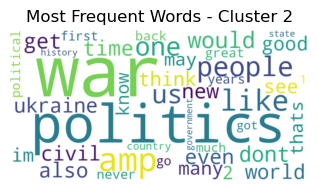

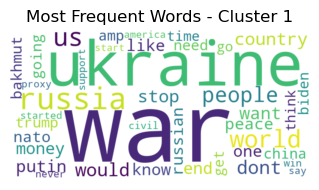

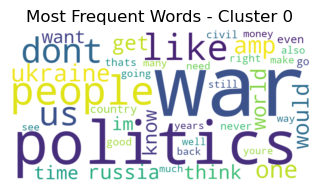

In [48]:
cluster_labels = cleanTweets['Cluster'].unique()
num_words = 40

for label in cluster_labels:
    cluster_data = cleanTweets[cleanTweets['Cluster'] == label]
    cluster_text = ' '.join(cluster_data['Tokenized Text'].apply(lambda x: ' '.join(x)))
    words = cluster_text.split()
    word_frequencies = Counter(words)
    wordcloud = WordCloud(**wordcloud_params)
    wordcloud.generate_from_frequencies(word_frequencies)
    
    plt.figure(figsize=(4, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Frequent Words - Cluster {label}')
    plt.axis('off')
    plt.tight_layout()

    plt.show()


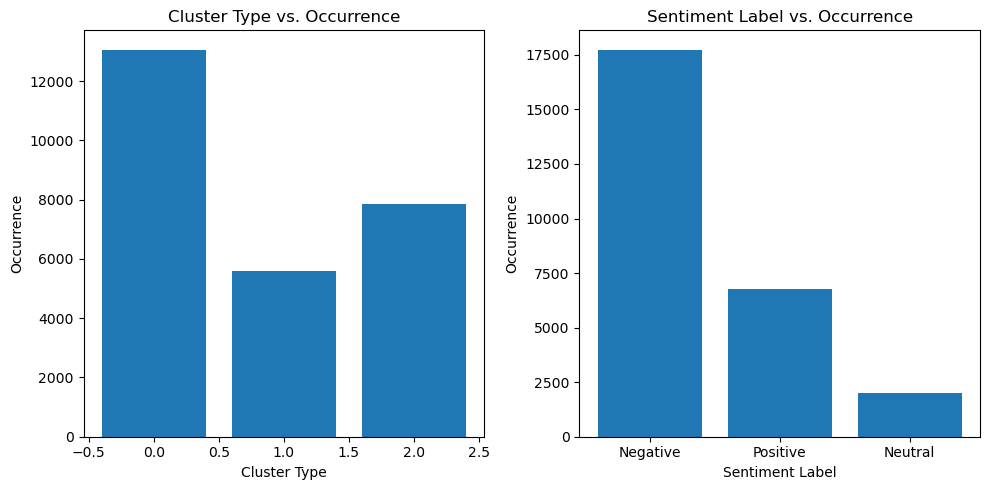

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
cluster_counts = cleanTweets['Cluster'].value_counts()
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster Type')
plt.ylabel('Occurrence')
plt.title('Cluster Type vs. Occurrence')

plt.subplot(1, 2, 2)
sentiment_counts = cleanTweets['Sentiment Label'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment Label')
plt.ylabel('Occurrence')
plt.title('Sentiment Label vs. Occurrence')

plt.tight_layout()


In [158]:
cleanTweets.to_csv('allData.csv', index=False)

Not Much difference is observed

## Classification using Classical ML Models

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score,precision_score,recall_score, f1_score


X = np.vstack(cleanTweets['Vectorized Text'].values)
X_train, X_test, y_train, y_test = train_test_split(X, cleanTweets['Cluster'], test_size=0.2, random_state=42)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(X_train)
normalized_test = scaler.fit_transform(X_test)


### Decision tree classifier 
Performing k fold cross validation first

In [20]:
dt_classifier = DecisionTreeClassifier()
dt_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5, error_score='raise')
print("Decision Tree Cross-Validation Scores:", dt_scores)

Decision Tree Cross-Validation Scores: [0.98562677 0.98680179 0.98444497 0.98232383 0.98515202]


In [21]:
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [22]:
dt_predictions = dt_classifier.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print("Decision Tree Accuracy:", dt_accuracy)

Decision Tree Accuracy: 0.9864278982092366


### Gradient boosting classifier

In [23]:
gb_classifier = GradientBoostingClassifier(verbose=1)
gb_scores = cross_val_score(gb_classifier, X_train, y_train, cv=5, error_score='raise')

      Iter       Train Loss   Remaining Time 
         1           0.8591            3.93m
         2           0.7241            3.88m
         3           0.6179            3.87m
         4           0.5315            3.86m
         5           0.4603            3.83m
         6           0.4006            3.81m
         7           0.3505            3.76m
         8           0.3075            3.69m
         9           0.2709            3.65m
        10           0.2395            3.61m
        20           0.0821            3.16m
        30           0.0371            2.81m
        40           0.0222            2.40m
        50           0.0157            2.02m
        60           0.0127            1.62m
        70           0.0107            1.22m
        80           0.0094           48.63s
        90           0.0083           24.41s
       100           0.0075            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8591            3.82m
        

In [24]:
print("Gradient Boosting Cross-Validation Scores:", gb_scores)

Gradient Boosting Cross-Validation Scores: [0.99222432 0.99269385 0.99010134 0.99127975 0.99057271]


In [25]:
gb_classifier.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.8590            5.67m
         2           0.7241            5.46m
         3           0.6180            5.32m
         4           0.5319            5.25m
         5           0.4602            5.16m
         6           0.4008            5.15m
         7           0.3503            5.08m
         8           0.3079            5.00m
         9           0.2711            4.93m
        10           0.2401            4.87m
        20           0.0825            4.38m
        30           0.0377            3.80m
        40           0.0228            3.24m
        50           0.0164            2.70m
        60           0.0131            2.16m
        70           0.0113            1.62m
        80           0.0099            1.08m
        90           0.0088           32.21s
       100           0.0079            0.00s


GradientBoostingClassifier(verbose=1)

In [26]:
gb_predictions = gb_classifier.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("Gradient Boosting Accuracy:", gb_accuracy)

Gradient Boosting Accuracy: 0.9926484448633365


### MultiNomial Naive Based Classifer

In [27]:
nb_classifier = MultinomialNB()
nb_scores = cross_val_score(nb_classifier, normalized_data, y_train, cv=5, error_score='raise')
print("NB Cross-Validation Scores:", nb_scores)

NB Cross-Validation Scores: [0.79594722 0.79731322 0.7935423  0.79990573 0.79542776]


In [28]:
nb_classifier.fit(normalized_data, y_train)
nb_predictions = nb_classifier.predict(normalized_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Based Accuracy:", nb_accuracy)

Naive Based Accuracy: 0.82186616399623


### Confusion Matrix and ROC Curve

In [29]:
dt_probs = dt_classifier.predict_proba(X_test)[:, 1]  
gb_probs = gb_classifier.predict_proba(X_test)[:, 1]  
nb_probs = nb_classifier.predict_proba(normalized_test)[:, 1] 

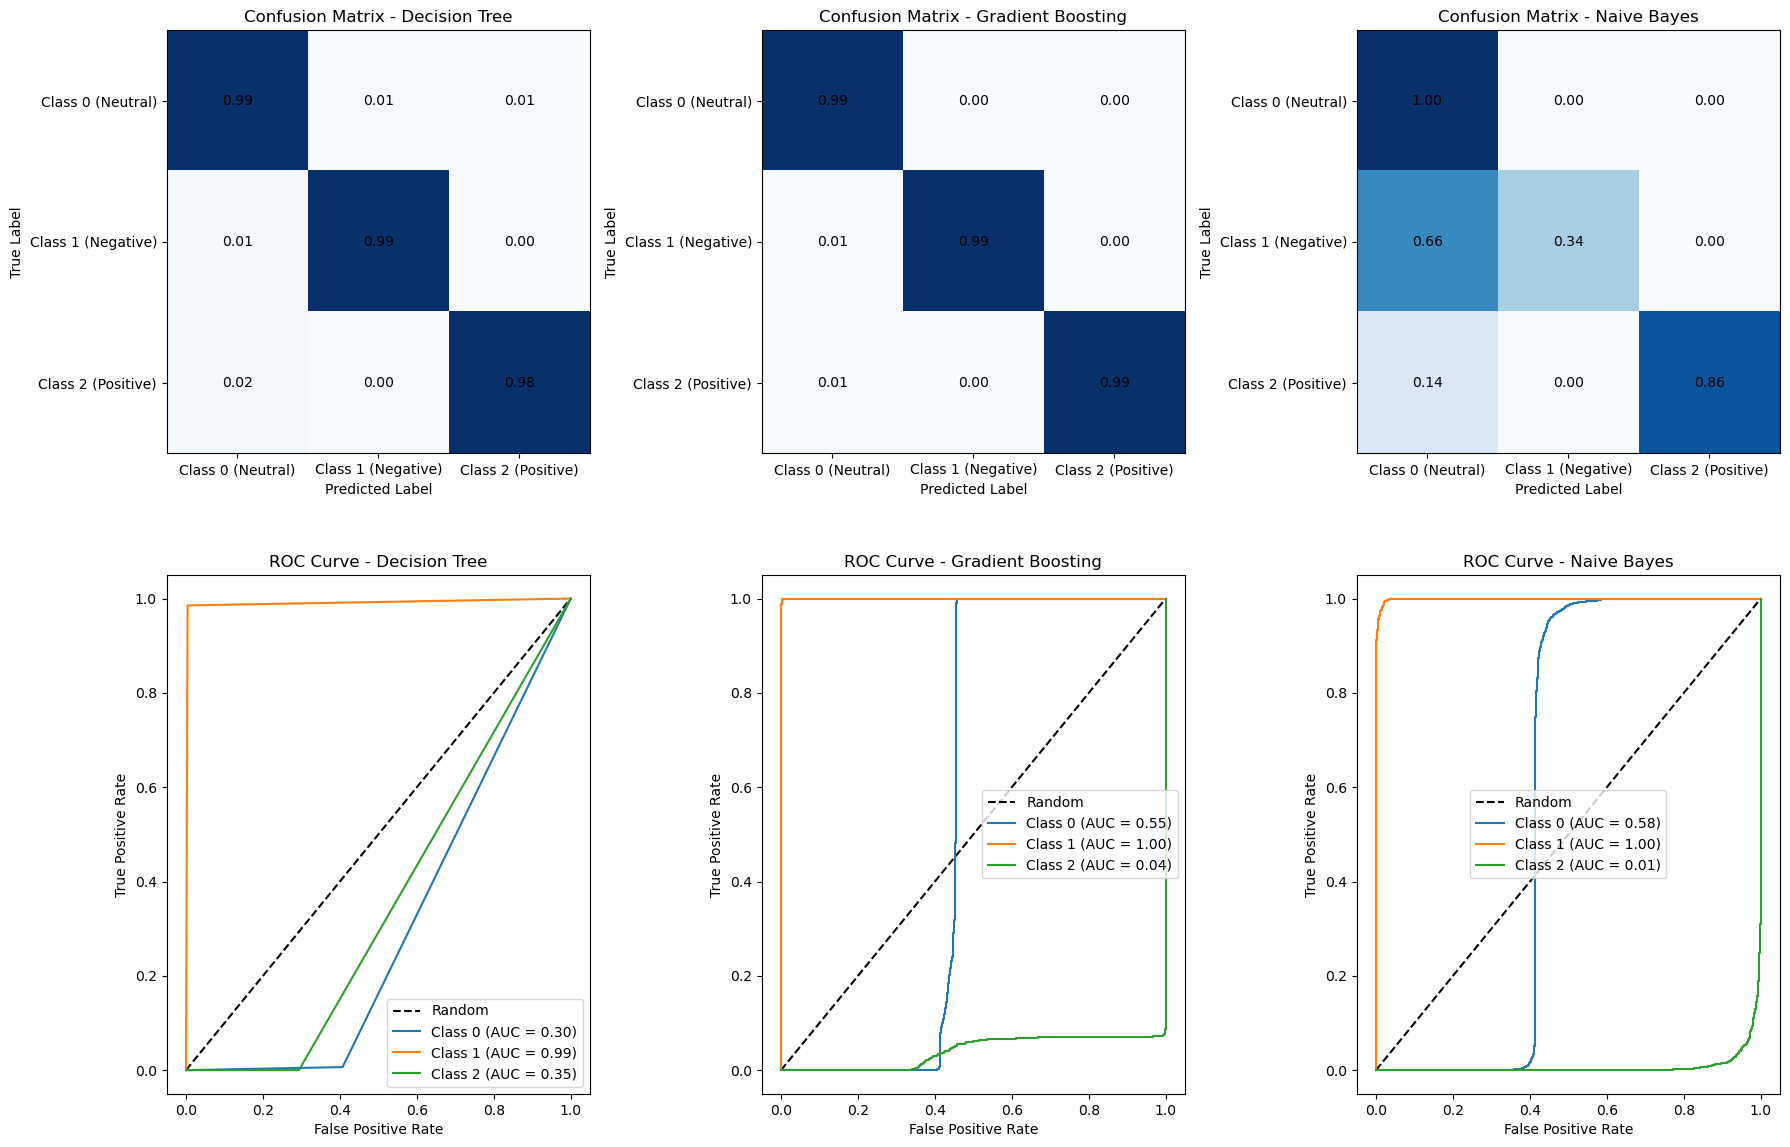

In [30]:
model_names = ['Decision Tree', 'Gradient Boosting', 'Naive Bayes']

# List of predicted labels for each model
y_preds = [dt_predictions, gb_predictions, nb_predictions]

# List of predicted probabilities for each model
y_probs = [dt_probs, gb_probs, nb_probs]
num_classes = 3

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Iterate over models
for i, model_name in enumerate(model_names):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_preds[i])
    # Compute accuracy for each class
    class_accuracy = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Plot confusion matrix with accuracy
    im = axs[0, i].imshow(class_accuracy, interpolation='nearest', cmap=plt.cm.Blues)
    axs[0, i].set_title(f'Confusion Matrix - {model_name}')
    axs[0, i].set_xlabel('Predicted Label')
    axs[0, i].set_ylabel('True Label')
    axs[0, i].set_xticks([0, 1, 2])
    axs[0, i].set_yticks([0, 1, 2])
    axs[0, i].set_xticklabels(['Class 0 (Neutral)', 'Class 1 (Negative)', 'Class 2 (Positive)'])
    axs[0, i].set_yticklabels(['Class 0 (Neutral)', 'Class 1 (Negative)', 'Class 2 (Positive)'])
    # Display accuracy values in each cell
    for j in range(num_classes):
        for k in range(num_classes):
            axs[0, i].text(k, j, f'{class_accuracy[j, k]:.2f}', ha='center', va='center', color='black')
    
    # Compute ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for class_idx in range(num_classes):
        fpr[class_idx], tpr[class_idx], _ = roc_curve(y_test == class_idx, y_probs[i])
        roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])
    # Plot ROC curves for each class
    axs[1, i].plot([0, 1], [0, 1], 'k--', label='Random')
    for class_idx in range(num_classes):
        axs[1, i].plot(fpr[class_idx], tpr[class_idx], label=f'Class {class_idx} (AUC = {roc_auc[class_idx]:.2f})')
    axs[1, i].set_xlabel('False Positive Rate')
    axs[1, i].set_ylabel('True Positive Rate')
    axs[1, i].set_title(f'ROC Curve - {model_name}')
    axs[1, i].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


####  Based on the analysis of the confusion matrices and ROC curves, we can draw some interesting insights regarding the performance of the classifiers. The results indicate that both the Decision Tree and Gradient Boosting classifiers performed well overall, with the Gradient Boosting classifier slightly outperforming the Decision Tree classifier. It is important to note that the Naive Bayes classifier showed some limitations in accurately classifying Class 1 (Negative) tweets. This could be attributed to the fact that Class 1 (Negative) and Class 2 (Positive) tweets often share similar words and expressions. Consequently, the Naive Bayes classifier struggled to differentiate between these two classes effectively. On the positive side, the Naive Bayes classifier demonstrated excellent performance in classifying Class 2 (Positive) tweets, achieving a perfect accuracy score. ll three classifiers exhibited good performance in classifying Class 0 'Neutral' tweets, with high accuracy scores across the board. However, when it comes to Class 1 (Negative) tweets, the Decision Tree classifier showcased the best performance among the three classifiers. In summary, the Gradient Boosting classifier demonstrated the best overall performance, closely followed by the Decision Tree classifier. The Naive Bayes classifier showed limitations in distinguishing between Class 1 (Negative) and Class 2 (Positive) tweets, which was expected due to the shared characteristics between these classes. Each classifier has its strengths and weaknesses, and the choice of classifier should be based on the specific requirements and priorities of the classification task at hand.

### Saving Gradient Boosting Model

In [31]:
import joblib
joblib.dump(gb_classifier, 'gradient_boosting_weights.pkl')

['gradient_boosting_weights.pkl']

In [32]:
cleanTweets.columns

Index(['Author', 'Tweet Text', 'Hashtags', 'Tokenized Text', 'Vectorized Text',
       'Cluster', 'Sentiment', 'Sentiment Label'],
      dtype='object')

## Neural Network

#### Utilizing the power of Long Short-Term Memory (LSTM) models, we can effectively handle sequential data such as text. We keep the architecture of the model very simple in order to obstain from overfit. Model consists of only LSTM layer with 8 units followed by dense layer with 8 layers and ouput dense layer for each of 3 classes

In [164]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
X = np.array(cleanTweets['Vectorized Text'])
y = np.array(cleanTweets['Cluster'])
X_concatenated = np.concatenate(X, axis=0)

X_reshaped = np.reshape(X_concatenated, (len(X), X[0].shape[0],1))

X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(8, input_shape=(100, 1))) 
model.add(Dense(8, activation='relu'))  
model.add(Dense(3, activation='softmax'))  
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 8)                 320       
                                                                 
 dense_163 (Dense)           (None, 8)                 72        
                                                                 
 dense_164 (Dense)           (None, 3)                 27        
                                                                 
Total params: 419
Trainable params: 419
Non-trainable params: 0
_________________________________________________________________


In [91]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
loss, accuracy = model.evaluate(X_val, y_val)
print('Validation Loss:', loss) 
print('Validation Accuracy:', accuracy)

Epoch 1/10
663/663 [==============================] - 31s 44ms/step - loss: 0.7519 - accuracy: 0.6568 - val_loss: 0.4903 - val_accuracy: 0.7727
Epoch 2/10
663/663 [==============================] - 29s 44ms/step - loss: 0.3541 - accuracy: 0.8656 - val_loss: 0.2681 - val_accuracy: 0.8895
Epoch 3/10
663/663 [==============================] - 30s 45ms/step - loss: 0.2126 - accuracy: 0.9208 - val_loss: 0.2538 - val_accuracy: 0.8946
Epoch 4/10
663/663 [==============================] - 27s 40ms/step - loss: 0.1513 - accuracy: 0.9436 - val_loss: 0.1235 - val_accuracy: 0.9519
Epoch 5/10
663/663 [==============================] - 31s 46ms/step - loss: 0.1319 - accuracy: 0.9504 - val_loss: 0.1116 - val_accuracy: 0.9615
Epoch 6/10
663/663 [==============================] - 27s 41ms/step - loss: 0.1196 - accuracy: 0.9556 - val_loss: 0.1194 - val_accuracy: 0.9533
Epoch 7/10
663/663 [==============================] - 27s 40ms/step - loss: 0.1098 - accuracy: 0.9591 - val_loss: 0.1148 - val_accuracy:

#### We got pretty good validation and train accuracy - loss results. As our dataset is unbalanced, as more  'Negative' data is present then 2 other classes. We can also evaluate f1 score and look at the convergence graphs to observe if our model overfits

In [92]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

166/166 [==============================] - 3s 17ms/step


In [93]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [94]:
y_train_multiclass = np.argmax(y_train_pred, axis=1)
y_val_multiclass = np.argmax(y_val_pred, axis=1)
f1_train = f1_score(y_train, y_pred_multiclass, average='weighted')
f1_val = f1_score(y_val, y_val_multiclass, average='weighted')

In [96]:
from tabulate import tabulate

metrics_data = {
    'Metric': ['Train Accuracy', 'Validation Accuracy', 'Train F1 Score', 'Validation F1 Score'],
    'Value': [train_accuracy[-1], val_accuracy[-1], f1_train, f1_val]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_table = metrics_df.values.tolist()

print(tabulate(metrics_table, headers=metrics_df.columns, tablefmt="fancy_grid"))


╒═════════════════════╤══════════╕
│ Metric              │    Value │
╞═════════════════════╪══════════╡
│ Train Accuracy      │ 0.96234  │
├─────────────────────┼──────────┤
│ Validation Accuracy │ 0.973233 │
├─────────────────────┼──────────┤
│ Train F1 Score      │ 0.979782 │
├─────────────────────┼──────────┤
│ Validation F1 Score │ 0.973173 │
╘═════════════════════╧══════════╛


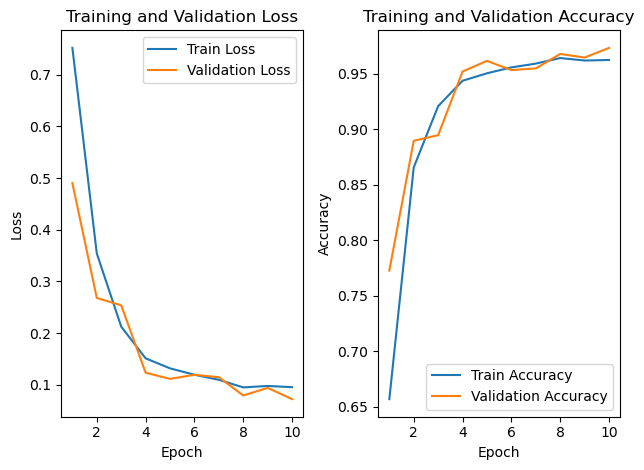

In [97]:
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()

plt.show()

#### Obtained resuls looks very good. But we can make try to optimize it. We can use GridSearch method to try different hyperparameters on the model. As no sign of overfit was observed from the obtaiend results, we can try increase the complexity of the model to achieve higher scores

### Choosing the best hyperparameters for LSTM model using GridSearch

In [165]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(units, activation):
    model = Sequential()
    model.add(LSTM(units, input_shape=(100, 1)))
    model.add(Dense(units, activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

modelUpd = KerasClassifier(build_fn=create_model, verbose=1)

param_grid = {
    'units': [16, 32],
    'activation': ['relu', 'tanh']
}

grid_search = GridSearchCV(estimator=modelUpd, param_grid=param_grid, cv=3)

grid_result = grid_search.fit(X_train, y_train)

print("Best Hyperparameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

663/663 [==============================] - 34s 49ms/step - loss: 0.4089 - accuracy: 0.8371
Best Hyperparameters:  {'activation': 'tanh', 'units': 16}
Best Accuracy:  0.9174208045005798


In [166]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
663/663 [==============================] - 36s 52ms/step - loss: 0.5783 - accuracy: 0.7693 - val_loss: 0.4382 - val_accuracy: 0.8100
Epoch 2/10
663/663 [==============================] - 34s 51ms/step - loss: 0.2696 - accuracy: 0.8981 - val_loss: 0.1767 - val_accuracy: 0.9378
Epoch 3/10
663/663 [==============================] - 37s 56ms/step - loss: 0.2372 - accuracy: 0.9054 - val_loss: 0.2068 - val_accuracy: 0.9156
Epoch 4/10
663/663 [==============================] - 35s 53ms/step - loss: 0.1849 - accuracy: 0.9213 - val_loss: 0.1413 - val_accuracy: 0.9450
Epoch 5/10
663/663 [==============================] - 35s 53ms/step - loss: 0.1484 - accuracy: 0.9367 - val_loss: 0.1603 - val_accuracy: 0.9270
Epoch 6/10
663/663 [==============================] - 35s 53ms/step - loss: 0.1290 - accuracy: 0.9461 - val_loss: 0.1073 - val_accuracy: 0.9580
Epoch 7/10
663/663 [==============================] - 34s 51ms/step - loss: 0.1054 - accuracy: 0.9569 - val_loss: 0.0757 - val_accuracy:

In [167]:
train_accuracy = best_model.score(X_train, y_train)
y_train_pred = best_model.predict(X_train)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

val_accuracy = best_model.score(X_val, y_val)
y_val_pred = best_model.predict(X_val)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

166/166 [==============================] - 4s 25ms/step


In [168]:
metrics_data = {
    'Metric': ['Train Accuracy', 'Validation Accuracy', 'Train F1 Score', 'Validation F1 Score'],
    'Value': [train_accuracy, val_accuracy, f1_train, f1_val]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_table = metrics_df.values.tolist()

print(tabulate(metrics_table, headers=metrics_df.columns, tablefmt="fancy_grid"))

╒═════════════════════╤══════════╕
│ Metric              │    Value │
╞═════════════════════╪══════════╡
│ Train Accuracy      │ 0.977517 │
├─────────────────────┼──────────┤
│ Validation Accuracy │ 0.978888 │
├─────────────────────┼──────────┤
│ Train F1 Score      │ 0.979782 │
├─────────────────────┼──────────┤
│ Validation F1 Score │ 0.973173 │
╘═════════════════════╧══════════╛


#### Saving Best model

In [169]:
joblib.dump(best_model, 'best_model.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-05-23 23:11:28        44496
metadata.json                                  2023-05-23 23:11:28           64
config.json                                    2023-05-23 23:11:28         2267


['best_model.pkl']

## Language Model (DistilBERT)

#### This part is in separate notebook Etap5.ipynb

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping

train_encodings = tokenizer(X_train, truncation = True, padding = True  )
val_encodings = tokenizer(X_val, truncation = True, padding = True)
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-5,               
    logging_dir='./logs',            
    eval_steps=100,
)
with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 5 )
trainer = TFTrainer(
    model=trainer_model,                 
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
)
trainer.train()